In [1]:
%%html
<img src="images/logo.png", width=600, height=600>

# Clustering et ACP

**Création de groupe de pays "identiques" à cibler pour notre expansion internationale,  
analyse des variables stratégiques à retenir,  
et recommandations.**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from my_module import *
import plotly.express as px
from bubbly.bubbly import bubbleplot
from plotly.offline import init_notebook_mode, iplot

# import required libraries for PCA
from sklearn import decomposition

# import required libraries for clustering
from pycaret.clustering import *
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

sns.set({"grid.color": ".4", "grid.linestyle": ":"}, palette="Dark2")
pd.set_option("display.float_format", lambda x: "%.2f" % x)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Import du df généré lors de la phase EDA / featuring

In [3]:
df_raw = pd.read_csv("data_prep/df_final.csv")
df_raw.head()

,Area,alpha-3,region,dist,Population (1000),pop_evo_rate,Urbanisation rate,gdp ($) per capita,Food supply quantity (g/capita/day),Chicken_meat_ratio,Livestock ratio (LSU %),Price indices,GPIndex(2015),Political stability,Animal protein ratio,AV Duties,Production per 1000 capita,Importation per 1000 capita
0,Afghanistan,AFG,Asia,5590.38,36296.11,0.34,0.25,513.09,5.00,0.10,2.04,113.83,82.65,-2.75,0.19,32.10,0.77,0.80
1,Algeria,DZA,Africa,1340.39,41389.19,0.21,0.72,4109.70,17.00,0.32,21.30,111.02,101.10,-0.83,0.28,30.00,6.35,0.00
2,Angola,AGO,Africa,6510.32,29816.77,0.43,0.65,4095.81,28.00,0.14,8.88,183.76,105.41,-0.32,0.30,10.00,1.35,8.92
3,Argentina,ARG,Americas,11072.25,43937.14,0.11,0.92,14627.62,119.00,0.37,2.66,143.48,104.41,0.02,0.64,10.00,48.16,0.05
4,Australia,AUS,Oceania,16975.46,24584.62,0.18,0.85,57628.86,131.00,0.28,2.89,100.53,108.17,1.00,0.67,0.00,50.01,0.12


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Area                                 114 non-null    object 
 1   alpha-3                              114 non-null    object 
 2   region                               114 non-null    object 
 3   dist                                 114 non-null    float64
 4   Population (1000)                    114 non-null    float64
 5   pop_evo_rate                         114 non-null    float64
 6   Urbanisation rate                    114 non-null    float64
 7   gdp ($) per capita                   114 non-null    float64
 8   Food supply quantity (g/capita/day)  114 non-null    float64
 9   Chicken_meat_ratio                   114 non-null    float64
 10  Livestock ratio (LSU %)              114 non-null    float64
 11  Price indices                   

Pas de valeurs manquantes

Après plusieurs tests, certaines variables sont non "significatives" et ne sont pas retenues pour la suite de nos analyses.

In [47]:
df = df_raw.drop(columns=["alpha-3", "region", "Price indices", "GPIndex(2015)", "pop_evo_rate", "Urbanisation rate", "Livestock ratio (LSU %)"], axis=1)
df.set_index("Area", inplace=True)
df.head()

,dist,Population (1000),gdp ($) per capita,Food supply quantity (g/capita/day),Chicken_meat_ratio,Political stability,Animal protein ratio,AV Duties,Production per 1000 capita,Importation per 1000 capita
Area,,,,,,,,,,
Afghanistan,5590.38,36296.11,513.09,5.00,0.10,-2.75,0.19,32.10,0.77,0.80
Algeria,1340.39,41389.19,4109.70,17.00,0.32,-0.83,0.28,30.00,6.35,0.00
Angola,6510.32,29816.77,4095.81,28.00,0.14,-0.32,0.30,10.00,1.35,8.92
Argentina,11072.25,43937.14,14627.62,119.00,0.37,0.02,0.64,10.00,48.16,0.05
Australia,16975.46,24584.62,57628.86,131.00,0.28,1.00,0.67,0.00,50.01,0.12


Il est primordial de standardiser les valeurs de nos variables afin d'éviter les déséquilibres quant à leur importance.  
Compte tenu de la présence d'"outliers" (notamment pour la population) et afin de garder la notion de distance entre nos variables, la méthode MinMaxScaler est retenu.

In [48]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df.columns
df_scaled.index = df.index
df_scaled.head()

,dist,Population (1000),gdp ($) per capita,Food supply quantity (g/capita/day),Chicken_meat_ratio,Political stability,Animal protein ratio,AV Duties,Production per 1000 capita,Importation per 1000 capita
Area,,,,,,,,,,
Afghanistan,0.32,0.02,0.00,0.03,0.10,0.06,0.16,0.19,0.01,0.01
Algeria,0.06,0.03,0.05,0.11,0.36,0.50,0.29,0.18,0.10,0.00
Angola,0.37,0.02,0.05,0.18,0.15,0.62,0.33,0.06,0.02,0.09
Argentina,0.65,0.03,0.17,0.80,0.42,0.70,0.86,0.06,0.74,0.00
Australia,1.00,0.01,0.69,0.88,0.31,0.92,0.91,0.00,0.76,0.00


# 1 - Hierarchical Clustering (ACH)

Utilisation de la méthode ward donnant de meilleurs résultats que les 3 autres (single, complete, average)

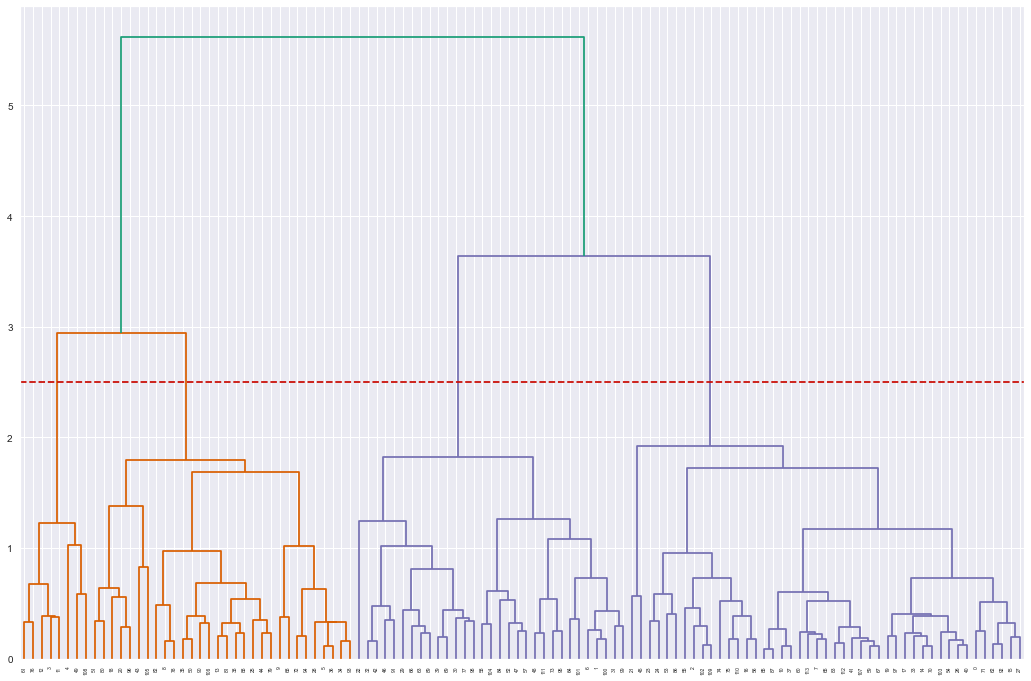

In [49]:
# Ward linkage: 
plt.figure(figsize=(18, 12))
mergings = linkage(df_scaled, method="ward", metric='euclidean')
dendrogram(mergings)
plt.axhline(2.5, c="r", ls="--")
plt.show();

Bien que subjectif, le choix de 4 clusters semblent le plus pertinent.  
Le choix de 2 clusters est trop minimaliste pour une étude de marché.  
Un plus grand nombre rendrait l'analyse des particularités des clusters plus difficiles.  
La méthode de clustering K-means utilisée par la suite nous permettra de confirmer cette affirmation.

In [50]:
# Récupération des numéros de clusters et intégration à df
cluster_labels = cut_tree(mergings, n_clusters=4).reshape(-1, )
df['Cluster_Labels'] = cluster_labels

Analyse de la moyenne de nos variables pour chaque cluster.

In [51]:
df.groupby("Cluster_Labels").mean()

,dist,Population (1000),gdp ($) per capita,Food supply quantity (g/capita/day),Chicken_meat_ratio,Political stability,Animal protein ratio,AV Duties,Production per 1000 capita,Importation per 1000 capita
Cluster_Labels,,,,,,,,,,
0,6389.12,92067.75,2151.91,13.60,0.16,-0.69,0.27,24.63,2.83,2.35
1,5978.08,50516.18,4784.69,52.48,0.56,-1.05,0.35,31.34,17.62,2.92
2,9664.89,85428.25,25683.74,122.62,0.55,-0.01,0.57,7.79,53.85,0.50
3,2947.10,31144.92,34118.88,55.70,0.32,0.63,0.57,2.22,24.17,10.19


Il ne s'agit pas d'apporter de conclusion hâtive pour le moment mais le cluster 3 semble plutôt intéressant compte tenu de ces 1ères observations :  
- Cluster de pays les moins éloignés  
- Taille du marché raisonnable  
- PIB par habitant le plus important et élevé  
- Disponibilité alimentaire en viande de poulets moyenne
- 1/3 de la viande consommée est du poulet
- Forte stabilité politique  
- Plus de la moitié des protéines animales consommées sont d'origine animale 
- Très faibles taxes d'importation
- Gros importateur de viande de poulets - les importations correspondent à la moitié de la production nationale  
**Les informations sont faites sur la base des moyennes observées !**

In [52]:
# Liste des pays du cluster cible (1ère approche)
df.index[df["Cluster_Labels"] == 3]

Index(['Austria', 'Belarus', 'Belgium', 'Bulgaria', 'Canada', 'Chile',
       'Czechia', 'Denmark', 'Finland', 'France', 'Germany', 'Greece',
       'Hong Kong', 'Hungary', 'Italy', 'Japan', 'Netherlands', 'Norway',
       'Poland', 'Portugal', 'Republic of Korea', 'Romania',
       'Russian Federation', 'Slovakia', 'Spain', 'Sweden', 'Switzerland',
       'Taiwan', 'United Arab Emirates',
       'United Kingdom of Great Britain and Northern Ireland'],
      dtype='object', name='Area')

NB : Les variables du marché français ont été conservés pour comparaison.

# 2 - K-means clustering

Utilisation d'une autre méthode de clustering pour une double validation.

In [53]:
# Utilisation d'un randon_state pour "répéter" le clustering
random_state = 42

Afin de déterminer le nombre optimal de cluster, utilisation de 2 méthodes :

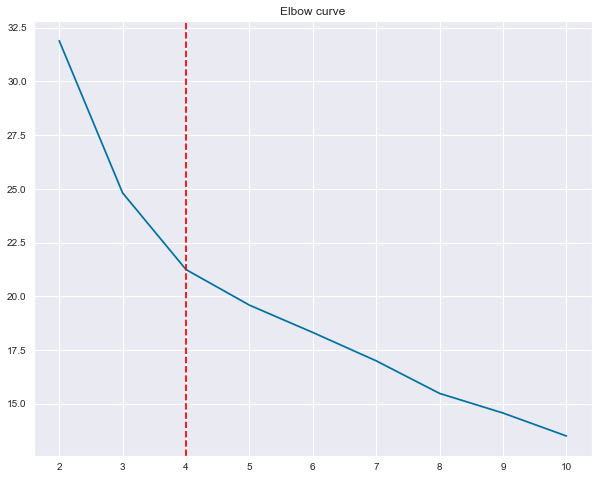

In [54]:
# Méthode 1 : Elbow-curve
inertia = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=random_state)
    kmeans.fit(df_scaled)   
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(10, 8))
plt.plot(range_n_clusters, inertia, 'bx-')
plt.axvline(4, c="red", ls="--")
plt.title("Elbow curve")
plt.show();

In [55]:
# Méthode 2 : Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=random_state)
    kmeans.fit(df_scaled)   
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    print(f"For n_clusters={num_clusters}, the silhouette score is {silhouette_avg}")

For n_clusters=2, the silhouette score is 0.32250862487674264
For n_clusters=3, the silhouette score is 0.33803443263860006
For n_clusters=4, the silhouette score is 0.3092644771695429
For n_clusters=5, the silhouette score is 0.24410762409373837
For n_clusters=6, the silhouette score is 0.243928038059782
For n_clusters=7, the silhouette score is 0.20910629405650202
For n_clusters=8, the silhouette score is 0.22741158157077607


**Nous allons retenir k=4 clusters pour notre analyse.**

In [56]:
# Final model with k=4
kmeans = KMeans(n_clusters=4, max_iter=50, random_state=random_state)
kmeans.fit(df_scaled)

KMeans(max_iter=50, n_clusters=4, random_state=42)

In [57]:
# Intégration des numéros de clusters dans df
df['Cluster_Id'] = kmeans.labels_

In [58]:
df.head()

,dist,Population (1000),gdp ($) per capita,Food supply quantity (g/capita/day),Chicken_meat_ratio,Political stability,Animal protein ratio,AV Duties,Production per 1000 capita,Importation per 1000 capita,Cluster_Labels,Cluster_Id
Area,,,,,,,,,,,,
Afghanistan,5590.38,36296.11,513.09,5.00,0.10,-2.75,0.19,32.10,0.77,0.80,0,2
Algeria,1340.39,41389.19,4109.70,17.00,0.32,-0.83,0.28,30.00,6.35,0.00,1,2
Angola,6510.32,29816.77,4095.81,28.00,0.14,-0.32,0.30,10.00,1.35,8.92,0,2
Argentina,11072.25,43937.14,14627.62,119.00,0.37,0.02,0.64,10.00,48.16,0.05,2,3
Australia,16975.46,24584.62,57628.86,131.00,0.28,1.00,0.67,0.00,50.01,0.12,2,3


Analyse de la moyenne de nos variables pour chaque cluster.

In [59]:
# Kmeans clustering
df.groupby("Cluster_Id").mean()

,dist,Population (1000),gdp ($) per capita,Food supply quantity (g/capita/day),Chicken_meat_ratio,Political stability,Animal protein ratio,AV Duties,Production per 1000 capita,Importation per 1000 capita,Cluster_Labels
Cluster_Id,,,,,,,,,,,
0,6493.77,53421.61,5410.91,57.91,0.61,-0.96,0.36,34.69,19.60,3.24,1.00
1,2530.22,26895.51,35976.39,49.56,0.29,0.64,0.58,2.69,20.42,11.03,2.78
2,6126.98,88786.84,1937.77,13.96,0.19,-0.84,0.26,24.86,3.24,2.09,0.14
3,8069.00,65735.15,19127.07,105.40,0.51,0.09,0.54,8.67,45.66,2.16,2.20


Bien qu'ayant utilisé une méthode de clustering différente, il semble que les mêmes 1ères observations que l'ACH sont observées pour notre cluster 1.  
1ères observations confirmées visuellement.

In [60]:
centroids = kmeans.cluster_centers_
centroid_original = scaler.inverse_transform(centroids)
df_centroids = pd.DataFrame(centroid_original)
df_centroids.columns = df.drop(columns=["Cluster_Labels", "Cluster_Id"]).columns
df_centroids

,dist,Population (1000),gdp ($) per capita,Food supply quantity (g/capita/day),Chicken_meat_ratio,Political stability,Animal protein ratio,AV Duties,Production per 1000 capita,Importation per 1000 capita
0,6493.77,53421.61,5410.91,57.91,0.61,-0.96,0.36,34.69,19.60,3.24
1,2530.22,26895.51,35976.39,49.56,0.29,0.64,0.58,2.69,20.42,11.03
2,6126.98,88786.84,1937.77,13.96,0.19,-0.84,0.26,24.86,3.24,2.09
3,8069.00,65735.15,19127.07,105.40,0.51,0.09,0.54,8.67,45.66,2.16


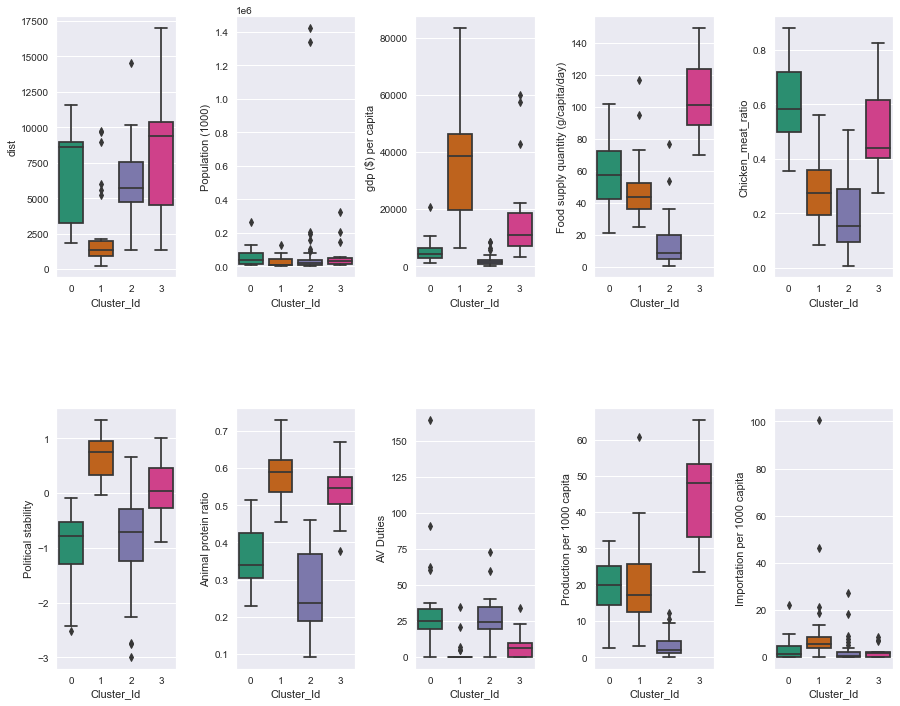

In [61]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for a, ax in zip(df.columns.drop("Cluster_Labels"), axs.ravel()):
    sns.boxplot(x='Cluster_Id', y=a, data=df, ax=ax)
plt.show();

# 3 - Comparaison des résultats des 2 méthodes de clustering

In [62]:
# K-means clustering - Liste des pays par cluster
for i in df["Cluster_Id"].unique():
    nb_country = (df[df["Cluster_Id"] == i].index).value_counts().sum()
    print(f"Cluster {i} - {nb_country} countries" )
    print(list(df[df["Cluster_Id"] == i].index))
    print("\n")

Cluster 2 - 50 countries
['Afghanistan', 'Algeria', 'Angola', 'Azerbaijan', 'Bangladesh', 'Benin', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Chad', 'China', 'Congo', 'Cuba', "Côte d'Ivoire", 'Democratic Republic of the Congo', 'Ethiopia', 'Ghana', 'Guinea', 'Haiti', 'India', 'Kenya', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Madagascar', 'Malawi', 'Mali', 'Mozambique', 'Nepal', 'Niger', 'Nigeria', 'Pakistan', 'Papua New Guinea', 'Paraguay', 'Rwanda', 'Senegal', 'Sierra Leone', 'Sudan', 'Syrian Arab Republic', 'Tajikistan', 'Togo', 'Tunisia', 'Turkmenistan', 'Uganda', 'United Republic of Tanzania', 'Uzbekistan', 'Viet Nam', 'Yemen', 'Zambia', 'Zimbabwe']


Cluster 3 - 15 countries
['Argentina', 'Australia', 'Belarus', 'Bolivia (Plurinational State of)', 'Brazil', 'Chile', 'Dominican Republic', 'Israel', 'Malaysia', 'Peru', 'Poland', 'Russian Federation', 'South Africa', 'Taiwan', 'United States of America']


Cluster 1 - 27 countries
['Austria', 'Belgium', 'Bulgaria',

In [63]:
# ACH - Liste des pays par cluster
for i in df["Cluster_Labels"].unique():
    nb_country = (df[df["Cluster_Labels"] == i].index).value_counts().sum()
    print(f"Cluster {i} - {nb_country} countries" )
    print(list(df[df["Cluster_Labels"] == i].index))
    print("\n")

Cluster 0 - 45 countries
['Afghanistan', 'Angola', 'Bangladesh', 'Benin', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Chad', 'China', 'Congo', 'Cuba', "Côte d'Ivoire", 'Democratic Republic of the Congo', 'Ethiopia', 'Ghana', 'Guinea', 'Haiti', 'India', 'Kazakhstan', 'Kenya', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Madagascar', 'Malawi', 'Mali', 'Mozambique', 'Nepal', 'Niger', 'Nigeria', 'Papua New Guinea', 'Paraguay', 'Rwanda', 'Senegal', 'Serbia', 'Sierra Leone', 'Sudan', 'Tajikistan', 'Turkmenistan', 'Uganda', 'United Republic of Tanzania', 'Uzbekistan', 'Viet Nam', 'Zambia', 'Zimbabwe']


Cluster 1 - 31 countries
['Algeria', 'Azerbaijan', 'Colombia', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Guatemala', 'Honduras', 'Indonesia', 'Iran (Islamic Republic of)', 'Iraq', 'Jordan', 'Lebanon', 'Libya', 'Mexico', 'Morocco', 'Myanmar', 'Nicaragua', 'Pakistan', 'Philippines', 'Saudi Arabia', 'South Africa', 'Sri Lanka', 'Syrian Arab Republic', 'Thailand', 'To

Visualisation géographique de nos clusters selon les 2 méthodes :

In [64]:
df_geo = df.reset_index().merge(df_raw[["Area", "alpha-3"]], on="Area")
df_geo["Cluster_Labels"] = df_geo["Cluster_Labels"].map({0: 2, 1: 0, 2: 3, 3: 1})

In [65]:
# K-means map
fig = px.choropleth(
    df_geo,
    locations="alpha-3",
    color="Cluster_Id",
    hover_name="Area",
    title="K_means clusters",
    color_continuous_scale="Viridis"
)
fig.update_layout(coloraxis_showscale=False, title_x=0.5, title_y=0.8)
# Export de la carte en html
fig.write_html("mapKM.html")

In [66]:
# ACH map
fig = px.choropleth(
    df_geo,
    locations="alpha-3",
    color="Cluster_Labels",
    hover_name="Area",
    title="ACH clusters",
    color_continuous_scale="Viridis"
)
fig.update_layout(coloraxis_showscale=False, title_x=0.5, title_y=0.8)
# Export de la carte en html
fig.write_html("mapACH.html")

In [67]:
%%html
<div class="box"><iframe src="mapKM.html" frameborder="0" scrolling="no" width="50%" height="550" align="left"></iframe></div>
<div class="box"><iframe src="mapACH.html" frameborder="0" scrolling="no" width="50%" height="550" align="right"></iframe></div>

Hormis quelques exceptions (Russie, Algérie notamment), les 2 modèles de clustering donnent des résultats similaires.  
Pour mémoire, le cluster 1 semble prometteur selon nos 1ères observations.

# 4 - ACP

La méthode ACP va nous permettre d'analyser la variabilité de nos individus (pays) et les liaisons entre nos variables.  
**En fonction de la priorté que l'on donnera à nos variables, nous pourrons alors déterminer le groupe de pays pour lequel il sera pertinent de faire une analyse de marché plus approfondie.**

In [68]:
# Initialisation de la PCA avec explication de la variance à 90%
pca = decomposition.PCA(n_components=0.9)
df_pca = pca.fit_transform(df_scaled)

In [69]:
pca.explained_variance_ratio_.cumsum()

array([0.454766  , 0.66681229, 0.76649671, 0.82047999, 0.8618555 ,
       0.90252354])

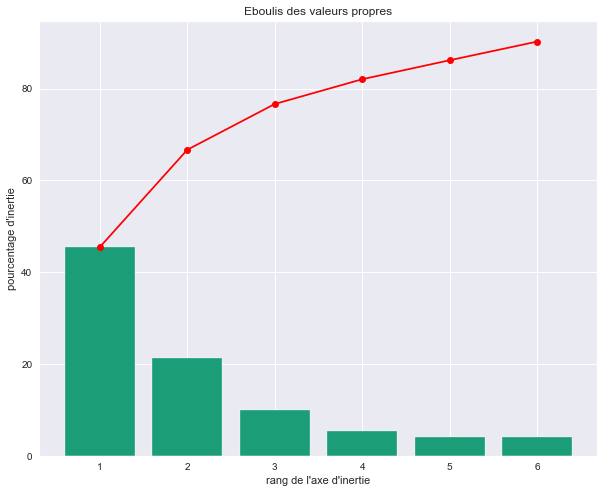

In [70]:
#Représentation de la variance expliquée
display_scree_plot(pca)

Les 6 1ères composantes expliquent 90% de la variance de nos 9 variables quantitatives.

### 4-1 Cercles de corrélations et plans factoriels

Corrélation des 9 variables par rapport aux 6 composantes principales

In [71]:
n_comp = 6
features = df_scaled.columns
pcs = pca.components_

##### F1/F2

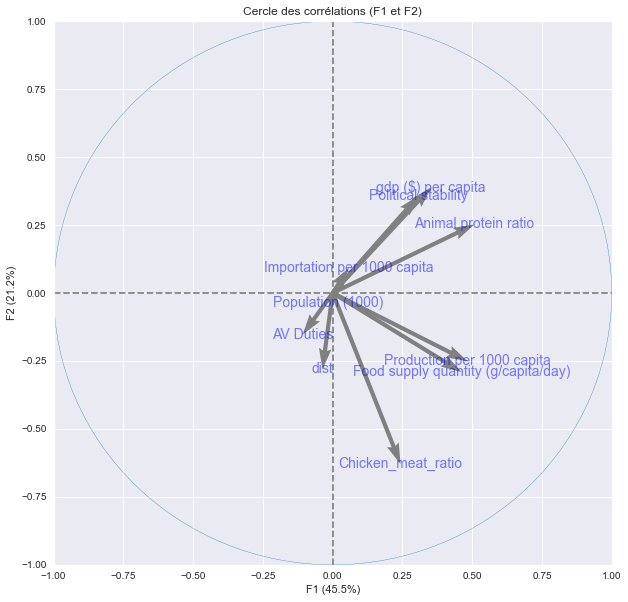

In [72]:
# Affichage du cercle des corrélations F1/F2
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

La représentativité des variables sur F1/F2 est plutôt moyenne (loin du cercle de corrélation).  
67% de la variance est expliquée par les 2 1ères composantes principales.
- Les variables Animal protein ratio, Production per 1000 capita et Food supply quantity sont moyennement corrélées à F1 (environ 0,50).  
- Chicken meat ratio est plus fortement corrélée à F2.  

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114 entries, Afghanistan to Zimbabwe
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   dist                                 114 non-null    float64
 1   Population (1000)                    114 non-null    float64
 2   gdp ($) per capita                   114 non-null    float64
 3   Food supply quantity (g/capita/day)  114 non-null    float64
 4   Chicken_meat_ratio                   114 non-null    float64
 5   Political stability                  114 non-null    float64
 6   Animal protein ratio                 114 non-null    float64
 7   AV Duties                            114 non-null    float64
 8   Production per 1000 capita           114 non-null    float64
 9   Importation per 1000 capita          114 non-null    float64
 10  Cluster_Labels                       114 non-null    int32  
 11  Cluster_Id            

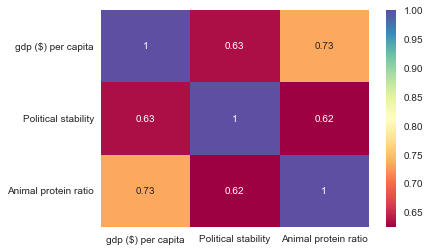

In [74]:
sns.heatmap(df[["gdp ($) per capita", "Political stability", "Animal protein ratio"]].corr(), annot=True, cmap='Spectral')
plt.show();

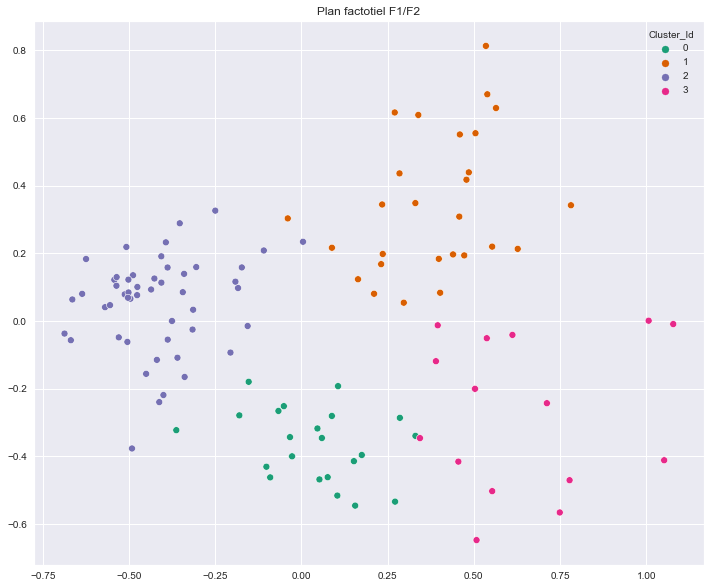

In [75]:
# Plan factoriel F1 F2
plt.figure(figsize=(12, 10))
sns.scatterplot(df_pca[:,0], df_pca[:,1], hue=df["Cluster_Id"], palette="Dark2")
plt.title("Plan factotiel F1/F2")
plt.show()

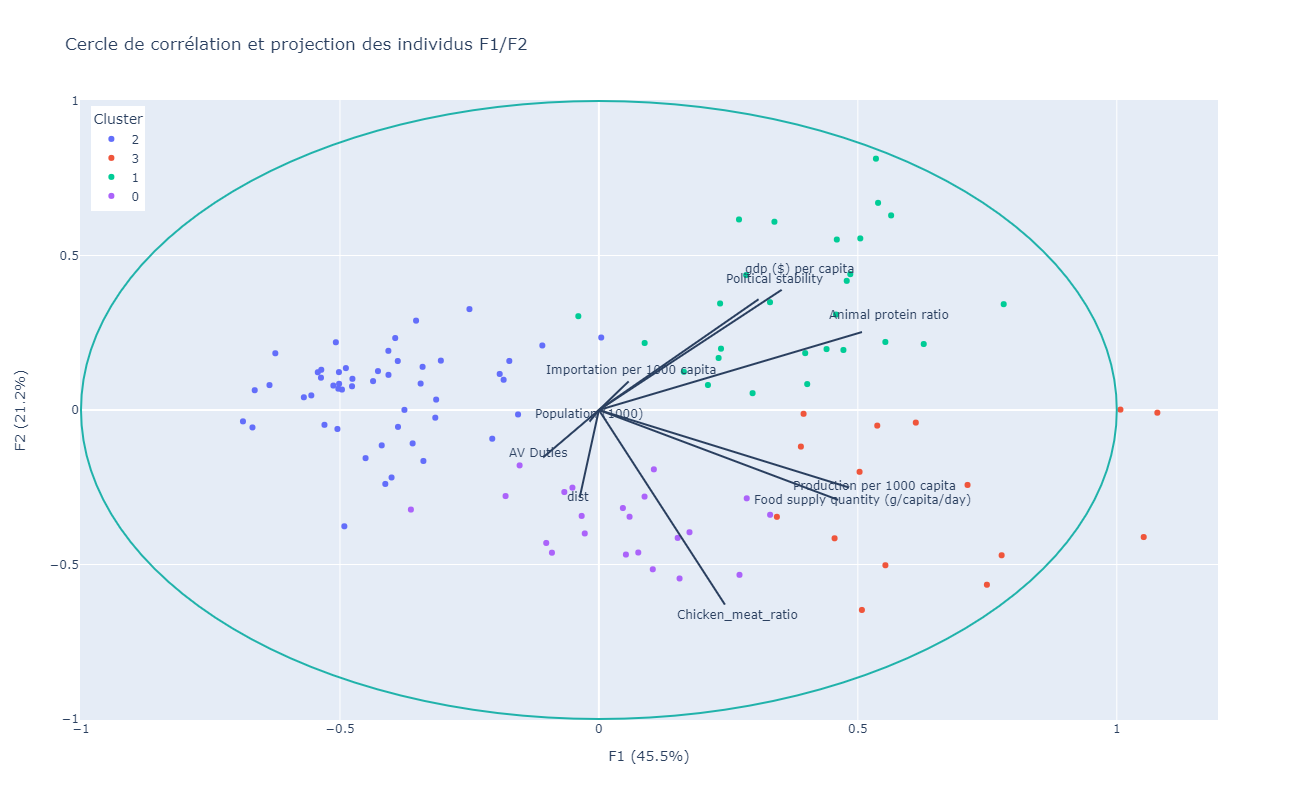

In [76]:
features = df_scaled.columns
loadings2 = pca.components_.T

labels = {
    str(i): f"F{i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter(
    df_pca, 
    x=0,
    y=1,
    width=850,
    height=800,
    color=df["Cluster_Id"].astype(str),
    hover_name=df_scaled.index,
    title="Cercle de corrélation et projection des individus F1/F2",
    labels={"color": "Cluster", "0": labels["0"], "1": labels["1"]},
)

fig.add_shape(
    type="circle",
    x0=-1,
    y0=-1,
    x1=1,
    y1=1,
    line_color="LightSeaGreen",
)

for i, feature in enumerate(features):
    fig.add_shape(
        type="line", x0=0, y0=0, x1=loadings2[i, 0], y1=loadings2[i, 1],
        xref='x1',
)
    
    fig.add_annotation(
        x=loadings2[i, 0]*1.1,
        y=loadings2[i, 1]*1.1,
        ax=0,
        ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
    
fig.show()

##### F3/F4

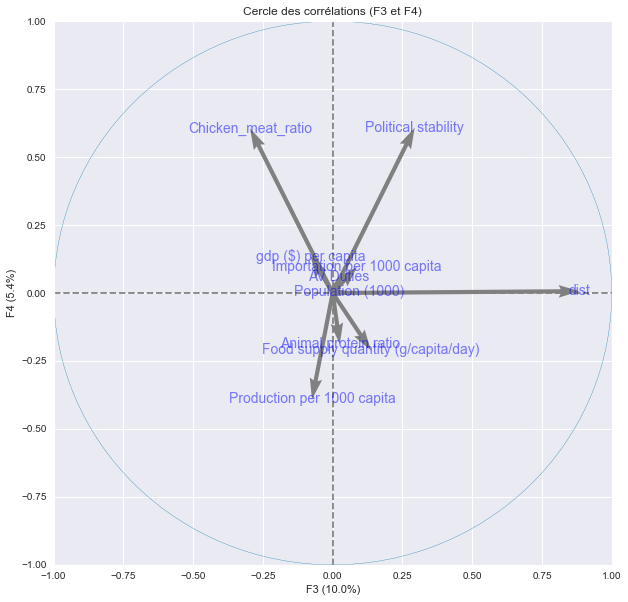

In [77]:
# Affichage du cercle des corrélations F3/F4
display_circles(pcs, n_comp, pca, [(2,3)], labels = np.array(features))

- La variable dist est fortement corrélée à F3.
- Chicken meat ration et Political stability sont bien corrélées à F4 (environ 0,60).

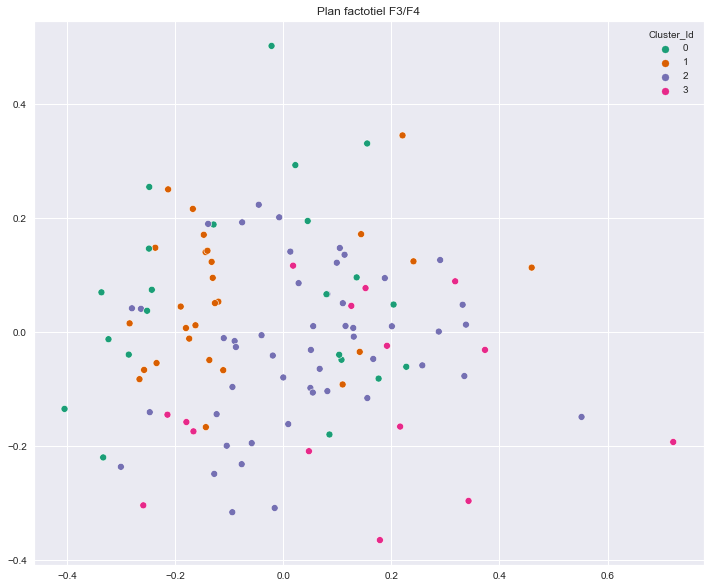

In [78]:
# Plan factoriel F3 F4
plt.figure(figsize=(12, 10))
sns.scatterplot(df_pca[:,2], df_pca[:,3], hue=df["Cluster_Id"], palette="Dark2")
plt.title("Plan factotiel F3/F4")
plt.show()

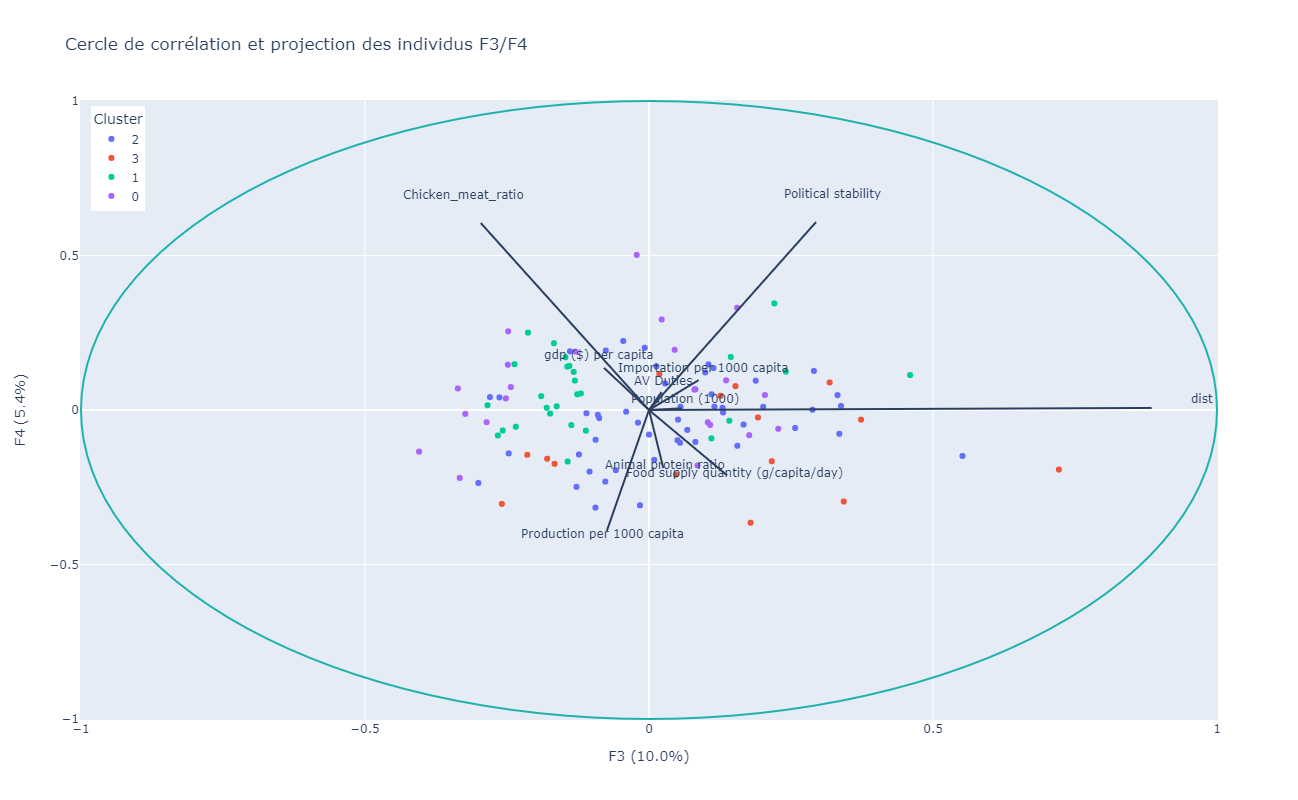

In [79]:
features = df_scaled.columns
loadings2 = pca.components_.T

labels = {
    str(i): f"F{i+1} ({var:.1f}%)" for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter(
    df_pca,
    x=2,
    y=3,
    width=850,
    height=800,
    color=df["Cluster_Id"].astype(str),
    hover_name=df_scaled.index,
    title="Cercle de corrélation et projection des individus F3/F4",
    labels={"color": "Cluster", "2": labels["2"], "3": labels["3"]},
)

fig.add_shape(
    type="circle",
    x0=-1,
    y0=-1,
    x1=1,
    y1=1,
    line_color="LightSeaGreen",
)

for i, feature in enumerate(features):
    fig.add_shape(
        type="line", x0=0, y0=0, x1=loadings2[i, 2], y1=loadings2[i, 3],
        xref='x1',
)
    
    fig.add_annotation(
        x=loadings2[i, 2]*1.1,
        y=loadings2[i, 3]*1.1,
        ax=0,
        ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
    
fig.show()

##### F5/F6

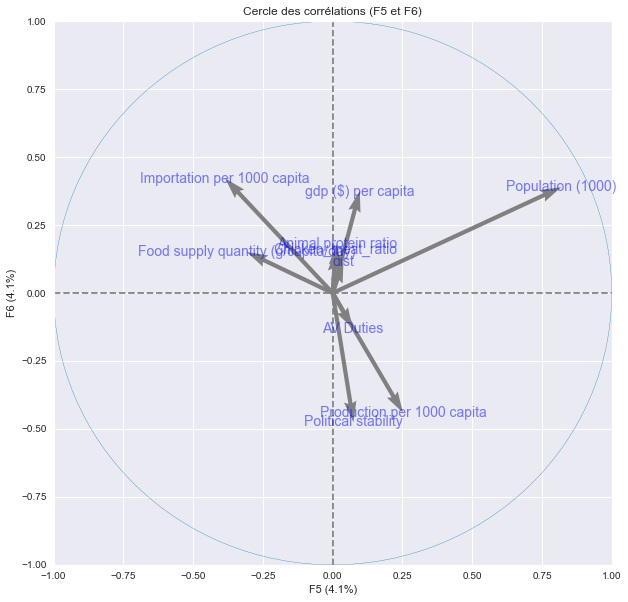

In [80]:
# Affichage du cercle des corrélations F5/F6
display_circles(pcs, n_comp, pca, [(4,5)], labels = np.array(features))

- Population très corrélée à F5
- Corrélation moyenne de Production et Political stability avec F6

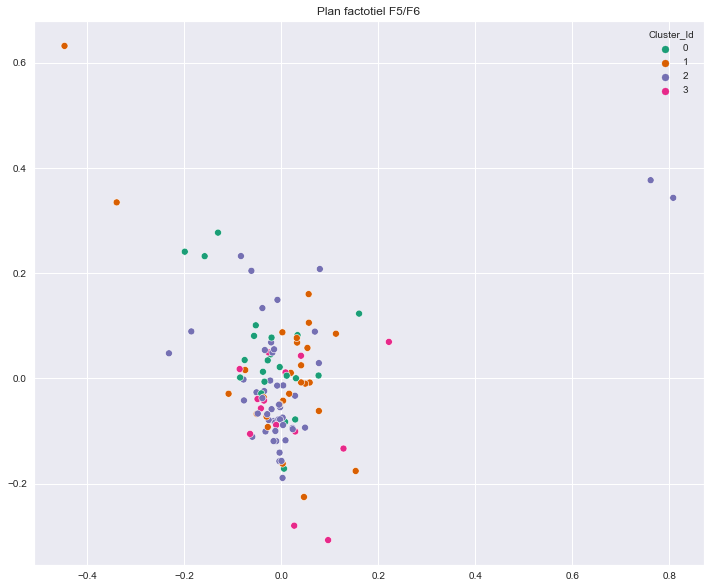

In [81]:
# Plan factoriel F4 F5
plt.figure(figsize=(12, 10))
sns.scatterplot(df_pca[:,4], df_pca[:,5], hue=df["Cluster_Id"], palette="Dark2")
plt.title("Plan factotiel F5/F6")
plt.show()

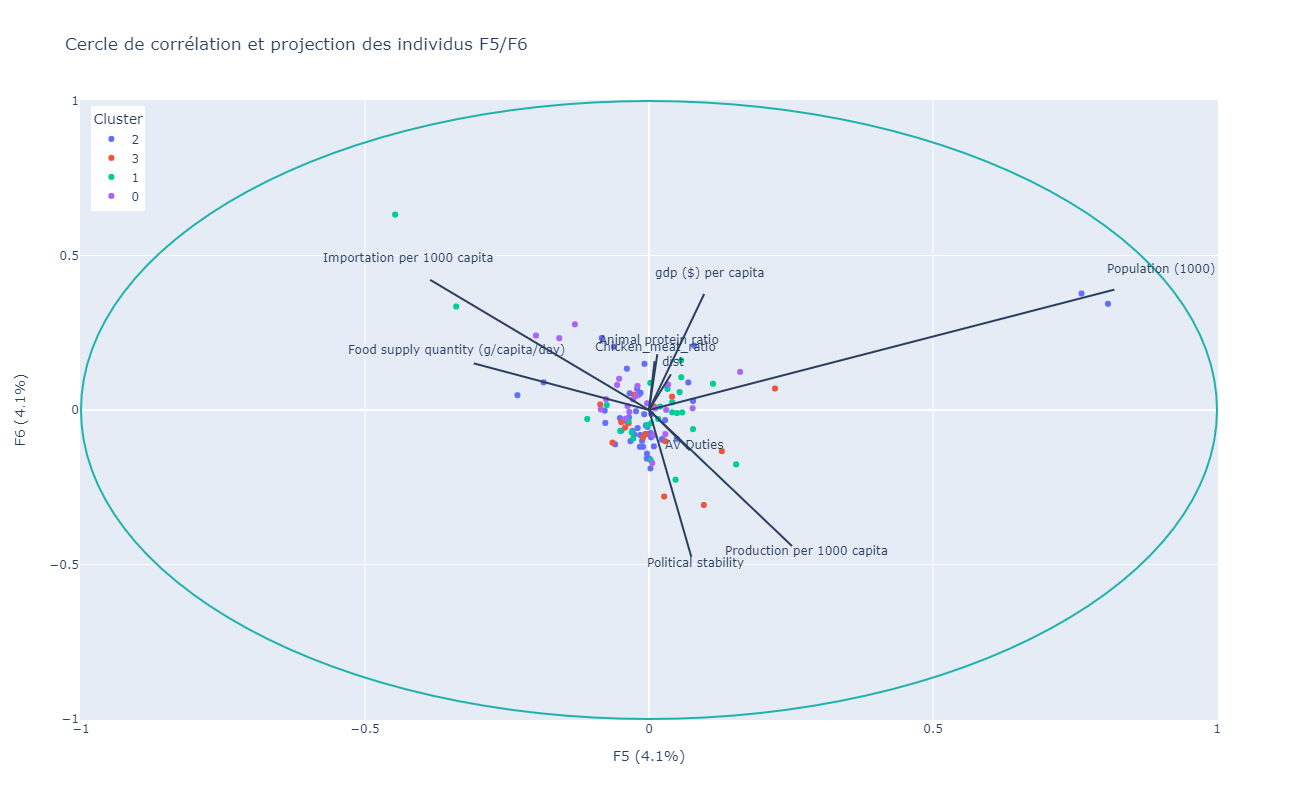

In [82]:
features = df_scaled.columns
loadings2 = pca.components_.T

labels = {
    str(i): f"F{i+1} ({var:.1f}%)" for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter(
    df_pca,
    x=4,
    y=5,
    width=850,
    height=800,
    color=df["Cluster_Id"].astype(str),
    hover_name=df_scaled.index,
    title="Cercle de corrélation et projection des individus F5/F6",
    labels={"color": "Cluster", "4": labels["4"], "5": labels["5"]},
)

fig.add_shape(
    type="circle",
    x0=-1,
    y0=-1,
    x1=1,
    y1=1,
    line_color="LightSeaGreen",
)

for i, feature in enumerate(features):
    fig.add_shape(
        type="line", x0=0, y0=0, x1=loadings2[i, 4], y1=loadings2[i, 5],
        xref='x1',
)
    
    fig.add_annotation(
        x=loadings2[i, 4]*1.1,
        y=loadings2[i, 5]*1.1,
        ax=0,
        ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
    
fig.show()

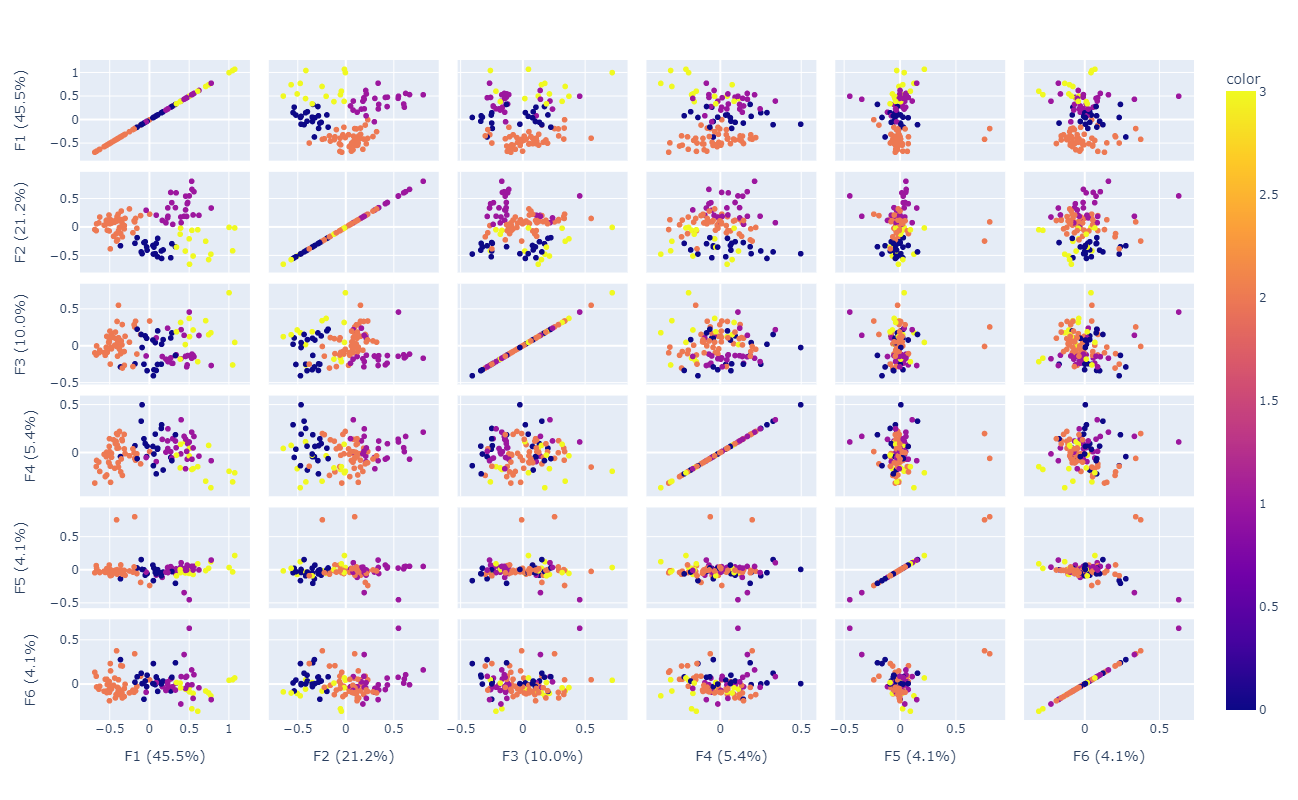

In [83]:
components = pca.fit_transform(df_scaled)
labels = {
    str(i): f"F{i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(6),
    width=900,
    height=800,
    color=df["Cluster_Id"]
)
fig.update_traces(diagonal_visible=True)
fig.show()

##### Résumé des corrélations entre les variables et les composantes principales

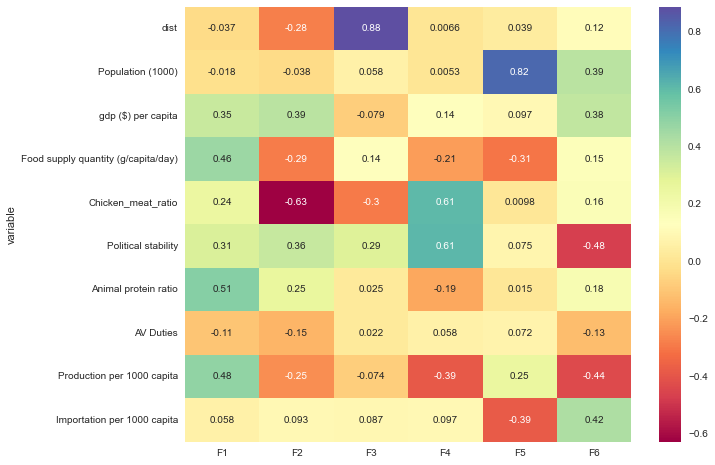

In [84]:
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["F"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df_scaled.columns.values
loadings_df = loadings_df.set_index('variable')

plt.figure(figsize=(10, 8))
sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

### 4-2 Projection 3D des pays selon les 3 1ères composantes

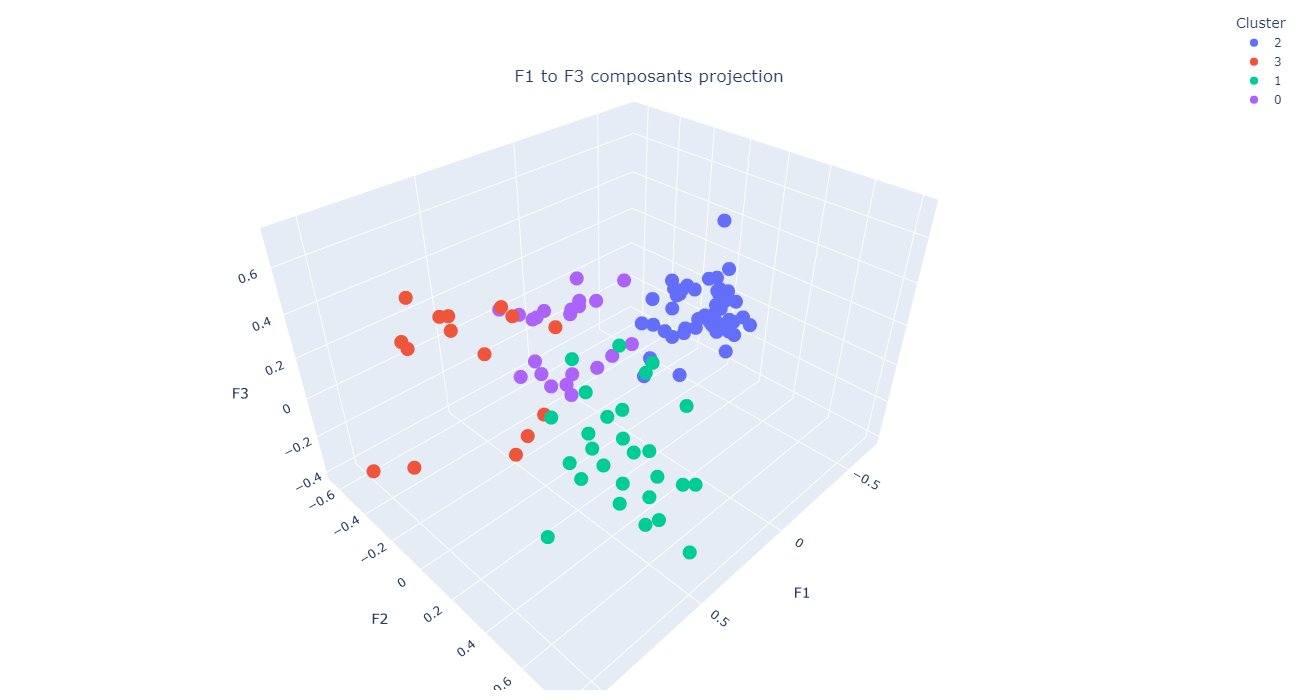

In [85]:
df_3d = pd.DataFrame(df_pca)
df_3d.index = df_scaled.index

x_vals = df_3d[0]
y_vals = df_3d[1]
z_vals = df_3d[2]
df["Cluster_Id"] = df["Cluster_Id"].astype("str")
fig = px.scatter_3d(
    x=x_vals,
    y=y_vals,
    z=z_vals,
    color=df["Cluster_Id"],
    width=800,
    height=700,
    labels={"color": "Cluster"},
    hover_name=df_3d.index,
)
fig.update_layout(
    scene=dict(xaxis_title="F1", yaxis_title="F2", zaxis_title="F3"),
    margin=dict(r=20, b=10, l=10, t=10),
)

fig.update_layout(
    title={
        'text': "F1 to F3 composants projection",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

# 5 - Analyse et choix des indicateurs clés

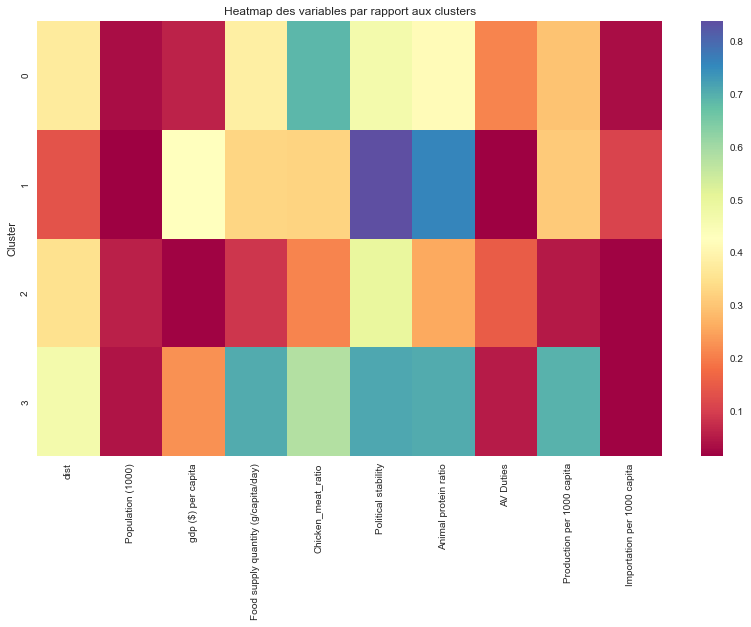

In [86]:
df_heatmap = df_scaled.reset_index()
df_heatmap = df_heatmap.merge(df.reset_index()[["Area", "Cluster_Id"]], on="Area")

plt.figure(figsize=(14, 8))
sns.heatmap(df_heatmap.groupby("Cluster_Id").mean(), cmap='Spectral')
plt.title("Heatmap des variables par rapport aux clusters")
plt.ylabel("Cluster")
plt.show();

In [87]:
df_indic = df.reset_index()
df_indic["Cluster_Id"] = df_indic["Cluster_Id"].astype("str")

Compte tenu des coûts de fabrication de nos produits élevés en France, le PIB par habitant est un bon indicateur de base pour prioriser le choix des autres indicateurs. La taille du marché est également conservé comme indicateur de base dans les visualisations suivantes (réprésenté par la taille du point).

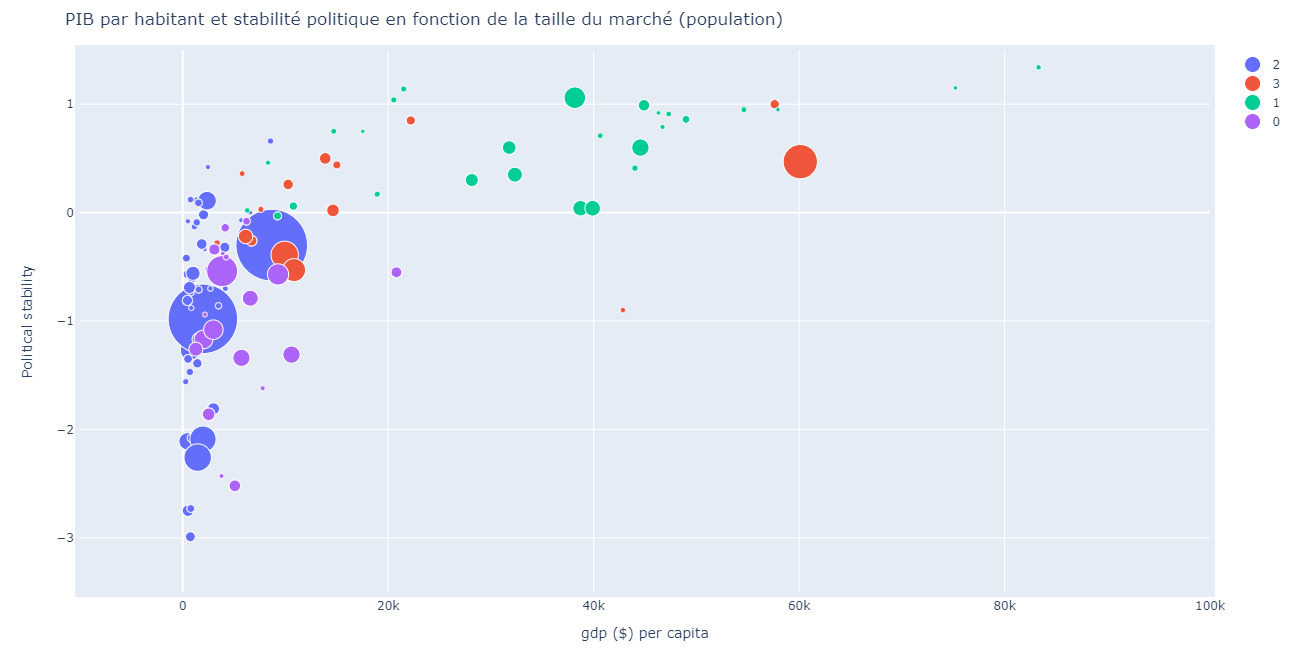

In [88]:
figure = bubbleplot(
    dataset=df_indic,
    x_column="gdp ($) per capita",
    y_column="Political stability",
    x_title="gdp ($) per capita",
    y_title="Political stability",
    title="PIB par habitant et stabilité politique en fonction de la taille du marché (population)",
    bubble_column="Area",
    size_column="Population (1000)",
    color_column="Cluster_Id",
    marker_opacity=1,
    colorscale="Portland",
    scale_bubble=0.8,
    height=650,
    show_colorbar=True,
    x_range=(-10000, 100000),
    y_range=(-3.5, 1.5)
)

iplot(figure, config={"scrollzoom": True})

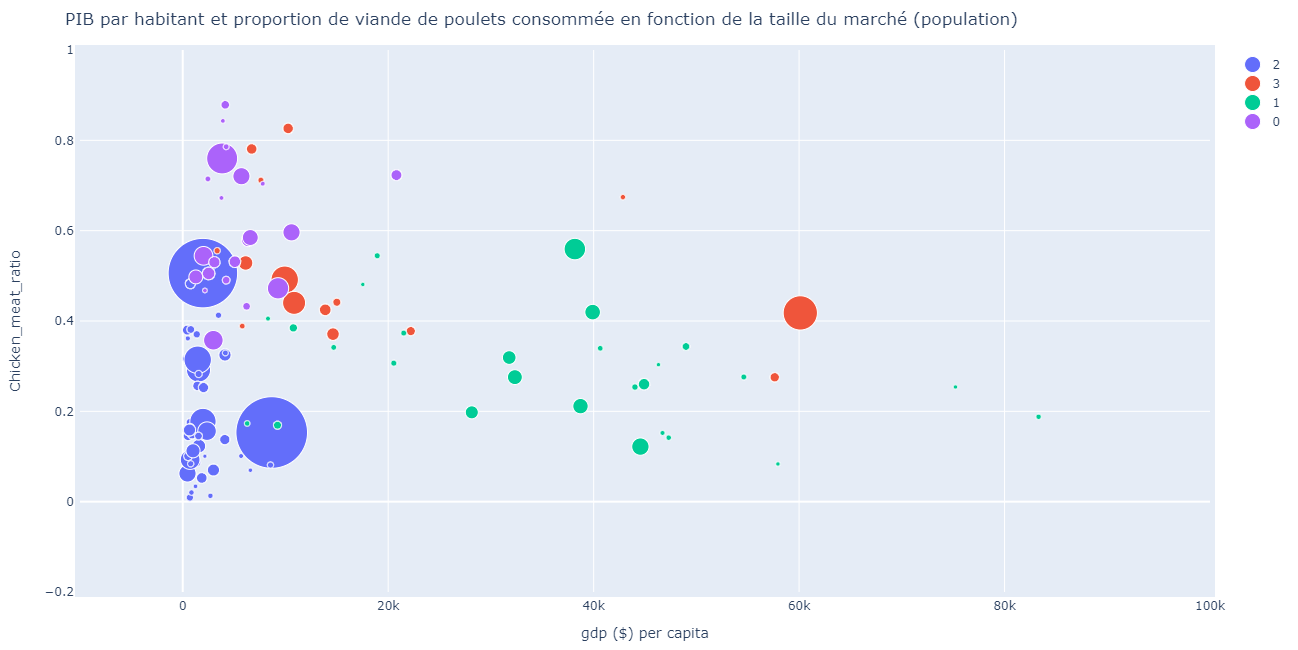

In [89]:
figure = bubbleplot(
    dataset=df_indic,
    x_column="gdp ($) per capita",
    y_column="Chicken_meat_ratio",
    x_title="gdp ($) per capita",
    y_title="Chicken_meat_ratio",
    title="PIB par habitant et proportion de viande de poulets consommée en fonction de la taille du marché (population)",
    bubble_column="Area",
    size_column="Population (1000)",
    color_column="Cluster_Id",
    marker_opacity=1,
    colorscale="Portland",
    scale_bubble=0.8,
    height=650,
    show_colorbar=True,
    x_range=(-10000, 100000),
    y_range=(-0.2, 1)
)

iplot(figure, config={"scrollzoom": True})

In [90]:
df_indic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Area                                 114 non-null    object 
 1   dist                                 114 non-null    float64
 2   Population (1000)                    114 non-null    float64
 3   gdp ($) per capita                   114 non-null    float64
 4   Food supply quantity (g/capita/day)  114 non-null    float64
 5   Chicken_meat_ratio                   114 non-null    float64
 6   Political stability                  114 non-null    float64
 7   Animal protein ratio                 114 non-null    float64
 8   AV Duties                            114 non-null    float64
 9   Production per 1000 capita           114 non-null    float64
 10  Importation per 1000 capita          114 non-null    float64
 11  Cluster_Labels                  

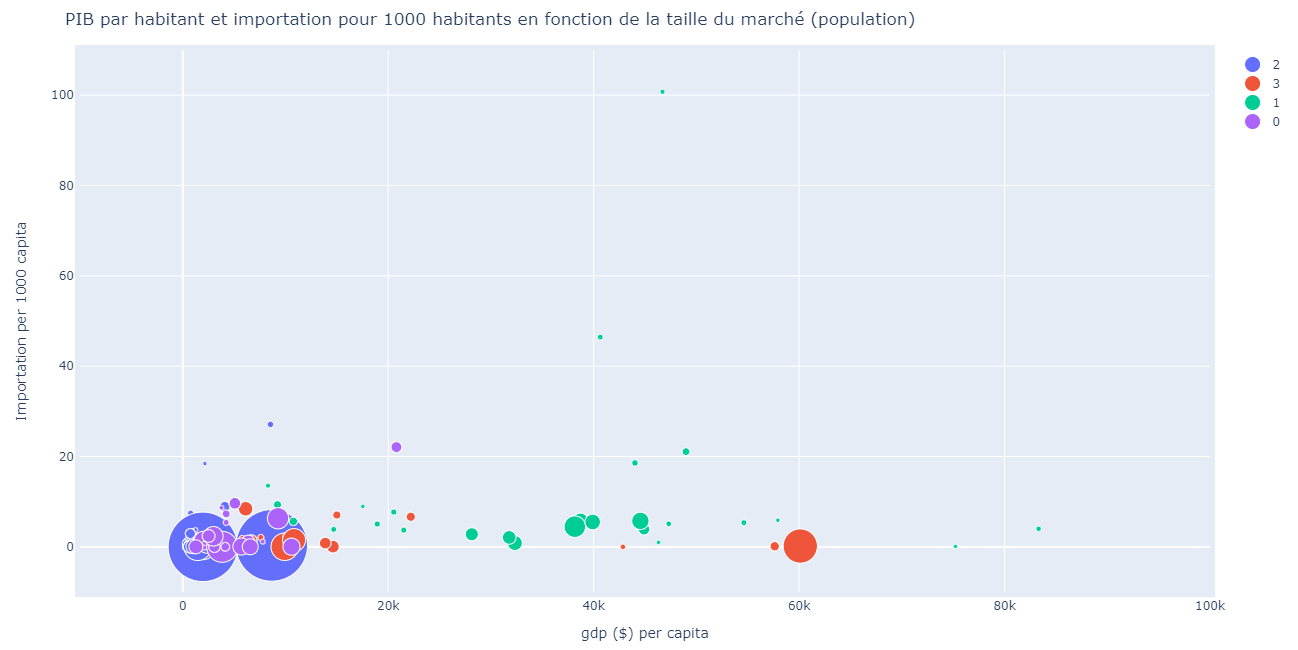

In [91]:
figure = bubbleplot(
    dataset=df_indic,
    x_column="gdp ($) per capita",
    y_column="Importation per 1000 capita",
    x_title="gdp ($) per capita",
    y_title="Importation per 1000 capita",
    title="PIB par habitant et importation pour 1000 habitants en fonction de la taille du marché (population)",
    bubble_column="Area",
    size_column="Population (1000)",
    color_column="Cluster_Id",
    marker_opacity=1,
    colorscale="Portland",
    scale_bubble=0.8,
    height=650,
    show_colorbar=True,
    x_range=(-10000, 100000),
    y_range=(-10, 110)
)

iplot(figure, config={"scrollzoom": True})

# 6 - Pour aller plus loin

### PCA puis clustering

In [92]:
df_pca2 = pd.DataFrame(df_pca)
df_pca2.head()

,0,1,2,3,4,5
0,-0.69,-0.04,-0.09,-0.32,-0.04,0.13
1,-0.31,0.03,-0.26,0.04,-0.01,-0.05
2,-0.31,0.16,0.13,-0.01,-0.08,-0.00
3,0.71,-0.24,0.34,-0.30,-0.01,-0.08
4,1.01,0.00,0.72,-0.19,0.04,0.04


In [93]:
# Final model with k=4
kmeans2 = KMeans(n_clusters=4, max_iter=50, random_state=random_state)
kmeans2.fit(df_scaled)

KMeans(max_iter=50, n_clusters=4, random_state=42)

In [94]:
df_pca2['Cluster2'] = kmeans2.labels_.astype(int)
df_pca2.index = df_scaled.index
df_pca2.head()

,0,1,2,3,4,5,Cluster2
Area,,,,,,,
Afghanistan,-0.69,-0.04,-0.09,-0.32,-0.04,0.13,2
Algeria,-0.31,0.03,-0.26,0.04,-0.01,-0.05,2
Angola,-0.31,0.16,0.13,-0.01,-0.08,-0.00,2
Argentina,0.71,-0.24,0.34,-0.30,-0.01,-0.08,3
Australia,1.01,0.00,0.72,-0.19,0.04,0.04,3


In [95]:
for i in df["Cluster_Id"].unique():
    nb_country = (df[df["Cluster_Id"] == i].index).value_counts().sum()
    print(f"Cluster {i} - {nb_country} countries" )
    print(list(df[df["Cluster_Id"] == i].index))
    print("\n")

Cluster 2 - 50 countries
['Afghanistan', 'Algeria', 'Angola', 'Azerbaijan', 'Bangladesh', 'Benin', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Chad', 'China', 'Congo', 'Cuba', "Côte d'Ivoire", 'Democratic Republic of the Congo', 'Ethiopia', 'Ghana', 'Guinea', 'Haiti', 'India', 'Kenya', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Madagascar', 'Malawi', 'Mali', 'Mozambique', 'Nepal', 'Niger', 'Nigeria', 'Pakistan', 'Papua New Guinea', 'Paraguay', 'Rwanda', 'Senegal', 'Sierra Leone', 'Sudan', 'Syrian Arab Republic', 'Tajikistan', 'Togo', 'Tunisia', 'Turkmenistan', 'Uganda', 'United Republic of Tanzania', 'Uzbekistan', 'Viet Nam', 'Yemen', 'Zambia', 'Zimbabwe']


Cluster 3 - 15 countries
['Argentina', 'Australia', 'Belarus', 'Bolivia (Plurinational State of)', 'Brazil', 'Chile', 'Dominican Republic', 'Israel', 'Malaysia', 'Peru', 'Poland', 'Russian Federation', 'South Africa', 'Taiwan', 'United States of America']


Cluster 1 - 27 countries
['Austria', 'Belgium', 'Bulgaria',

In [96]:
for i in df_pca2["Cluster2"].unique():
    nb_country = (df_pca2[df_pca2["Cluster2"] == i].index).value_counts().sum()
    print(f"Cluster {i} - {nb_country} countries" )
    print(list(df_pca2[df_pca2["Cluster2"] == i].index))
    print("\n")

Cluster 2 - 50 countries
['Afghanistan', 'Algeria', 'Angola', 'Azerbaijan', 'Bangladesh', 'Benin', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Chad', 'China', 'Congo', 'Cuba', "Côte d'Ivoire", 'Democratic Republic of the Congo', 'Ethiopia', 'Ghana', 'Guinea', 'Haiti', 'India', 'Kenya', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Madagascar', 'Malawi', 'Mali', 'Mozambique', 'Nepal', 'Niger', 'Nigeria', 'Pakistan', 'Papua New Guinea', 'Paraguay', 'Rwanda', 'Senegal', 'Sierra Leone', 'Sudan', 'Syrian Arab Republic', 'Tajikistan', 'Togo', 'Tunisia', 'Turkmenistan', 'Uganda', 'United Republic of Tanzania', 'Uzbekistan', 'Viet Nam', 'Yemen', 'Zambia', 'Zimbabwe']


Cluster 3 - 15 countries
['Argentina', 'Australia', 'Belarus', 'Bolivia (Plurinational State of)', 'Brazil', 'Chile', 'Dominican Republic', 'Israel', 'Malaysia', 'Peru', 'Poland', 'Russian Federation', 'South Africa', 'Taiwan', 'United States of America']


Cluster 1 - 27 countries
['Austria', 'Belgium', 'Bulgaria',